#0) <b>Imports and Loading</b>

In [1]:
import sys, os, traceback, io, itertools, requests, datetime

# Import pandas for reading the .csv file.
import pandas as pd, numpy as np, datetime as dt

# Import matplotlib for plotting.
from matplotlib import pyplot as plt, dates as mdates
%matplotlib inline
import datetime as dt

# Try to import Facebook Research's Prophet, 
# else attempt to download it, 
# else exit the program.
try:
  from prophet import Prophet
  from prophet.plot import plot_plotly, plot_components_plotly
  from prophet.diagnostics import cross_validation, performance_metrics
except:
  try:
    !pip install prophet
    from prophet import Prophet
    from prophet.plot import plot_plotly, plot_components_plotly
    from prophet.diagnostics import cross_validation, performance_metrics
  except Exception as ins:
    FAIL_MSSG = f"\n\n Could not install prophet, error was:\n{ins.args}\n\n"
    print(FAIL_MSSG)
    sys.exit(1)

     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 184kB 17.3MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639766 sha256=c4f9609997ed4e96c13c216e15c2e98dc06b56a8538d97f6c838a32abcaa83e7
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [2]:
# Define St Luis FRED's link to USA unemployment rate from 1948 to date (2nd may 2021)
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=ope"\
      "n%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12"\
      "&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=UNRATE"\
      "&scale=left&cosd=1948-01-01&coed=2021-03-01&line_color=%234572a7&link_values=false&line_style=solid&"\
      "mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&"\
      "line_index=1&transformation=lin&vintage_date=2021-05-02&revision_date=2021-05-02&nd=1948-01-01"

# Download the data and load it into a Pandas object
r = requests.post(url)
if r.ok:
  data = r.content.decode('utf8')
  df = pd.read_csv(io.StringIO(data))
else:
  print('Download failed!')

# Show data in console's stdout
print(df.head())

         DATE  UNRATE
0  1948-01-01     3.4
1  1948-02-01     3.8
2  1948-03-01     4.0
3  1948-04-01     3.9
4  1948-05-01     3.5


#1) <b>Definition of auxiliary functions</b>

In [25]:
def plotter(v, nm='y', q=False, display=True, label=''):
  if not q:
    f, ax = plt.subplots(figsize=(20,5))
  else:
    f,ax =q
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=1440))
  try:
    ax.scatter([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in v['ds']],v[nm], label=label)
    ax.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in v['ds']],v[nm])
  except:
    #[forecast.ds.tolist()[i].__str__().split(' ')[0]
    ax.scatter(v['ds'],v[nm], label=label)
    ax.plot(v['ds'],v[nm])
  f.autofmt_xdate()
  if display:
    ax.legend()
    plt.show()
  else:
    return f,ax

def visualizer(dfin, num_months, dont_use_last_months):
  L = len(dfin) - dont_use_last_months
  df_train = dfin.iloc[:L,:]
  df_test = dfin.iloc[-L:,:]


  # Instantiate the model using the best parameters, which by default were:
  # {'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 0.005, 'changepoint_range': 1.0}
  m = Prophet(**best_params)

  # Train
  m.fit(df_train)

  # Make predictions over said amount of months
  future = m.make_future_dataframe(periods=num_months, freq='M')
  forecast = m.predict(future)

  # Plot interactively
  figure = plot_plotly(m, forecast)
  figure.show()

  # Plot against actual data considering only from the month INIT
  INIT = 500
  q = plotter(dfin.iloc[INIT:,:], nm='y', q=False, display=False, label='true data')
  q[1].grid()
  q[1].axvline(forecast.ds.tolist()[-num_months], 0,1, color='r', lw=4, label='last data considered')
  plotter(forecast.iloc[INIT:,:], nm='yhat', q=q, display=True, label='mean prediction')
  return forecast['yhat'].tolist()[-num_months:]

#2) <b>Optimization of Hiper-parameters:</b> <br><i>looking for the set that minimizes RMSE of 1-year monthly predictions</i>

In [ ]:
# Set up data's columns to ['ds','y'] as requested in Prophet's docs
df.columns = ['ds','y']

# Define the dataset for cross validating
df_cv = df

param_grid = {  
    'changepoint_prior_scale': [50,10,5, 1, 0.5, 0.1, 0.01, 0.001, 0.0005, 0.0001],
    'seasonality_prior_scale': [0.005, 0.01, 0.1, 0.5],#, 0.1, 1.0, 10.0],
    'changepoint_range':[1],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = pd.to_datetime([df.ds.tolist()[i] for i in [100,200,300,400,500,600,700]])

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='365 days', parallel="processes",  cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff260fd0710>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff26c78e190>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff26c78e050>
INFO:prophet:Disabling weekly seasonality. Run prophet 

    changepoint_prior_scale  ...      rmse
0                   50.0000  ...  0.377081
1                   50.0000  ...  0.379509
2                   50.0000  ...  0.405286
3                   50.0000  ...  0.419744
4                   10.0000  ...  0.376882
5                   10.0000  ...  0.384964
6                   10.0000  ...  0.402280
7                   10.0000  ...  0.414384
8                    5.0000  ...  0.373152
9                    5.0000  ...  0.372533
10                   5.0000  ...  0.396445
11                   5.0000  ...  0.413131
12                   1.0000  ...  0.412602
13                   1.0000  ...  0.417803
14                   1.0000  ...  0.423281
15                   1.0000  ...  0.434629
16                   0.5000  ...  0.551897
17                   0.5000  ...  0.554871
18                   0.5000  ...  0.553456
19                   0.5000  ...  0.559934
20                   0.1000  ...  0.943350
21                   0.1000  ...  0.925540
22         

#3) <b>Visualization of the seasonal component of the best  model</b>

In [ ]:
# Extract the best parameters, i.e. those that minimize the rmse
# they were: 
# {'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 0.005, 'changepoint_range': 1.0}
BEST_INDEX = np.argmin(tuning_results.rmse)
best_params = {k:tuning_results.iloc[BEST_INDEX,:][k] for k in tuning_results.columns if k!='rmse'}
print(f'\n\nbest parameters are: {best_params}\n\n')

# Instantiate the model using the best parameters
m = Prophet(**best_params)

# Train
m.fit(df)

# Predict
future = m.make_future_dataframe(periods=6, freq='M')
forecast = m.predict(future)

# Show the fitting for seasonal unemployment
plot_components_plotly(m, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




best parameters are: {'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 0.01, 'changepoint_range': 1.0}




#4) <b>Visualize the model's prediction for the aftermath of the covid-19 pandemic</b>
<br><i>WARNING: the amount of monhts (i.e. "num_months", the number "11" used as third positional argument in the only function called in the following line) should be changed as the database from St Luis FRED may update itself, so the number of months ignored should be increased. Date: 02 May 2021</i>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


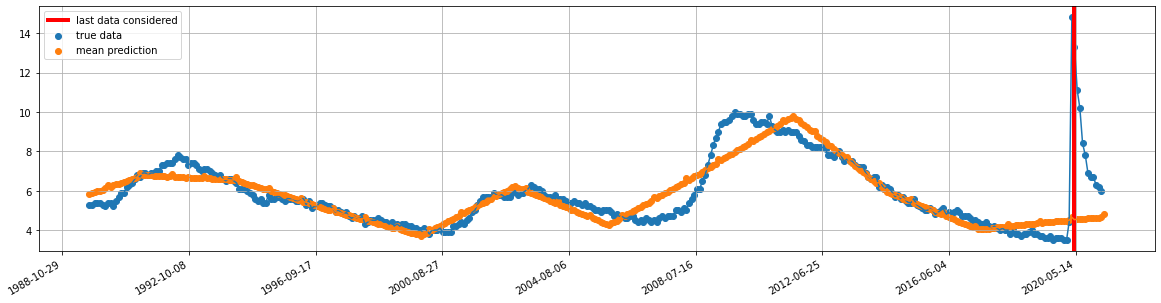

In [26]:
forecast_real_data = visualizer(df, 12, 11)

#5) <b>Had the covid-19 crash happened in a time of relatively high seasonal high-employment, what would the recovery trend have been?</b>
<br><i>WARNING: the amount of monhts (i.e. "num_months", the number "11" used as third positional argument in the only function called in the following line) should be changed as the database from St Luis FRED may update itself, so the number of months ignored should be increased. Date: 02 May 2021</i>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(14, 2)


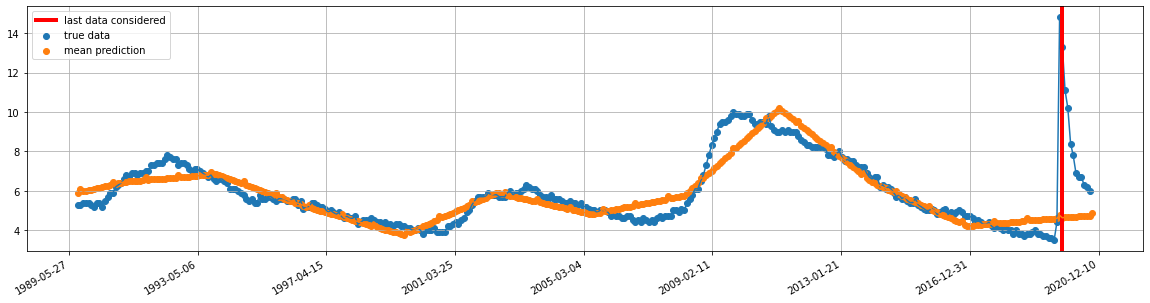

In [27]:
num_months=14
new_tail = pd.DataFrame([df.iloc[-num_months-6:-6,0].tolist(), df.iloc[-num_months:,1].tolist()]).T
print(new_tail.shape)
new_tail.columns = ['ds','y']
contrafactual_data = pd.concat([df.iloc[:-num_months-6,:], new_tail], 0)
forecast_shifted_data = visualizer(contrafactual_data, 12, num_months-3)

#6) <b>Comparing both scenarios</b>


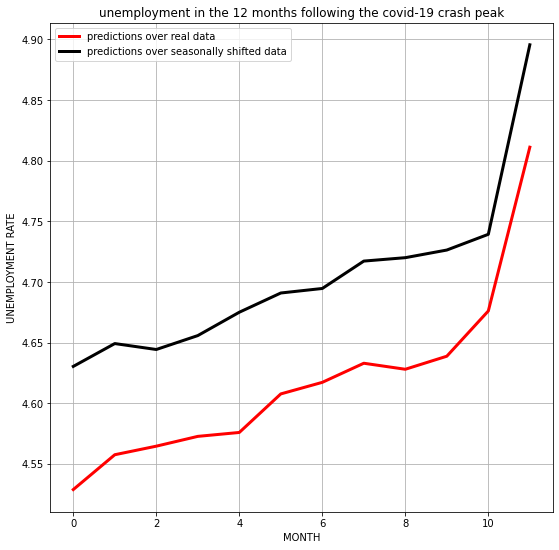

In [36]:
f, ax = plt.subplots(1,1,figsize=(9,9))
ax.plot(forecast_real_data, c='r', label='predictions over real data', lw=3)
ax.plot(forecast_shifted_data, c='k', label='predictions over seasonally shifted data', lw=3)
ax.set_title('unemployment in the 12 months following the covid-19 crash peak')
ax.set_xlabel('MONTH')
ax.set_ylabel('UNEMPLOYMENT RATE')
ax.legend(); plt.grid()
